In [33]:
#########################################################################
# Usando una red convolucional preentrenada
# Ejecutando la base convolucional sobre nuestro conjunto de datos 
#########################################################################
#registrando su salida en una matriz Numpy 
#luego usando estos datos como entrada a un clasificador independiente densamente conectado 
#solo requiere ejecutar la base convolucional una vez para cada imagen de entrada, 
#solucion rapida y economica
#esta técnica no nos permitiría aprovechar el aumento de datos.
#Realizado por Ximena Rios- Universidad del Valle
#########################################################################

In [34]:
#Parametros generales
IMG_ALTO = 150
IMG_ANCHO =150
LOTE_SIZE = 20 #tamaño de los lotes de datos

#Definir los directorios de trabajo 
import os
base_dir = os.getcwd() + '/base_datos/'
train_dir = os.getcwd() + '/base_datos/train/'
validacion_dir= os.getcwd() + '/base_datos/validacion/'
test_dir = os.getcwd() + '/base_datos/test/'

#Definir el nombre para guardar el modelos y los datos 
#nombre='Xception'
#nombre='VGG16'
nombre='VGG19'
#nombre='ResNet50'
#nombre='ResNetV2'
#nombre='InceptionV3'
#nombre='InceptionResNetV2'
#nombre='MobileNet'
#nombre='MobileNetV2'
#nombre='DenseNet121'
#nombre='NASNet'

In [35]:
#crear una instancia de la base convolucional VGG16
#from keras.applications import Xception
#from keras.applications import VGG16
from keras.applications import VGG19
#from keras.applications import ResNet50
#from keras.applications import ResNetV2
#from keras.applications import InceptionV3
#from keras.applications import InceptionResNetV2
#from keras.applications import MobileNet
#from keras.applications import MobileNetV2
#from keras.applications import DenseNet121
#from keras.applications import NASNet

#conv_base = Xception(
#conv_base = VGG16(
#conv_base = VGG16(weights='imagenet',  #punto de control de peso inicializar el modelo
conv_base = VGG19(
#conv_base = ResNet50(
#conv_base = ResNetV2(
#conv_base = InceptionV3(
#conv_base = InceptionResNetV2(
#conv_base = MobileNet(
#conv_base = MobileNetV2(
#conv_base = DenseNet121( #DenseNet169 DenseNet201
#conv_base = NASNet(
    include_top=False, #No incluir la red densamente conectada
    input_shape=(150, 150, 3)) #forma del tensor de entrada
#https://keras.io/applications/

In [36]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [37]:
#Extraer las carateristicas usando la base convolucional preentrenada
##########################################################################
#Ejecutando la base convolucional sobre nuestro conjunto de datos, 
#registrando su salida en una matriz Numpy 
#luego usando estos datos como entrada a un clasificador independiente densamente conectado 
#solo requiere ejecutar la base convolucional una vez para cada imagen de entrada, 
#solucion rapida y economica
#esta técnica no nos permitiría aprovechar el aumento de datos.
##########################################################################
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
#Crear una instancia de la clase ImageDataGenerator para el aumento de datos
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
#alto=5;ancho=5;canales=2048; #Xception datos de ultima capa de la conv base
#alto=4;ancho=4;canales=512; #VGG16 datos de ultima capa de la conv base
alto=4;ancho=4;canales=512; #VGG19 datos de ultima capa de la conv base
#alto=5;ancho=5;canales=2048; #ResNet50 datos de ultima capa de la conv base
#alto=3;ancho=3;canales=2048; #InceptionV3 datos de ultima capa de la conv base
#alto=3;ancho=3;canales=1536; #InceptionResNetV2 datos de ultima capa de la conv base
#alto=4;ancho=4;canales=1024; #DenseNet121 datos de ultima capa de la conv base

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, alto, ancho, canales))
    labels = np.zeros(shape=(sample_count,15))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 4660)
validation_features, validation_labels = extract_features(validacion_dir, 580)
test_features, test_labels = extract_features(test_dir, 580)


Found 4664 images belonging to 15 classes.
Found 591 images belonging to 15 classes.
Found 585 images belonging to 15 classes.


In [38]:
# Las caracteristicas obtenidas tienen la forma (samples,4,4,512) para VGG16
#para alimentar un clasificador densamente conectado debemos primero aplanarlas
train_features = np.reshape(train_features, (4660, alto * ancho * canales))
validation_features = np.reshape(validation_features, (580, alto * ancho * canales))
test_features = np.reshape(test_features, (580, alto * ancho * canales))

In [39]:
#Definir el clasificador densamente conectado
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=alto * ancho * canales))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(15, activation='softmax'))
#capa densa de tamaño 15. para cada entrada la red saca un vector de 15 dimensiones. cada entrada en este vector codifica una clase diferente de salida 
# activacion softmax significa que la red puede sacar una distribucion de probabilidad sobre 15 diferentes clases de salida

In [40]:
#compilar
from keras import optimizers
model.compile(optimizer='rmsprop',
    loss='categorical_crossentropy', #funcion de activacion para clasificacion multiclase
    metrics=['acc'])  #categorical_crossentropy, espera que las etiquetas sigan una codificación categórica
    #categorical--> will be 2D one-hot encoded labels

In [41]:
#Entrenar la red
history = model.fit(train_features, train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels))

Train on 4660 samples, validate on 580 samples
Epoch 1/30
4660/4660 [==============================] - 2s 376us/step - loss: 2.3602 - acc: 0.2768 - val_loss: 1.8407 - val_acc: 0.4655
Epoch 2/30
4660/4660 [==============================] - 1s 253us/step - loss: 1.9791 - acc: 0.3691 - val_loss: 1.7484 - val_acc: 0.4362
Epoch 3/30
4660/4660 [==============================] - 1s 252us/step - loss: 1.8173 - acc: 0.4159 - val_loss: 1.5285 - val_acc: 0.5224
Epoch 4/30
4660/4660 [==============================] - 1s 252us/step - loss: 1.7362 - acc: 0.4412 - val_loss: 1.5321 - val_acc: 0.5172
Epoch 5/30
4660/4660 [==============================] - 1s 253us/step - loss: 1.6586 - acc: 0.4689 - val_loss: 1.5870 - val_acc: 0.4931
Epoch 6/30
4660/4660 [==============================] - 1s 258us/step - loss: 1.6018 - acc: 0.4893 - val_loss: 1.3766 - val_acc: 0.5690
Epoch 7/30
4660/4660 [==============================] - 1s 251us/step - loss: 1.5520 - acc: 0.5049 - val_loss: 1.2968 - val_acc: 0.6086
E

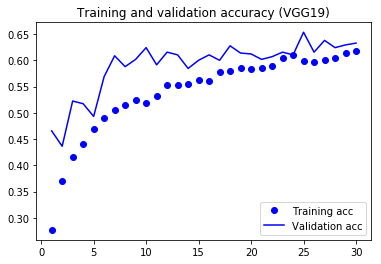

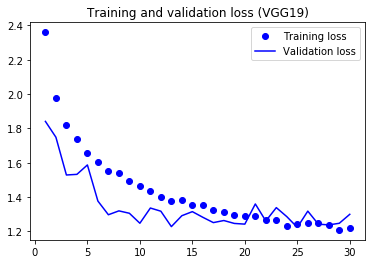

In [44]:
#graficar
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') #Entrenamiento acc
plt.plot(epochs, val_acc, 'b', label='Validation acc') #Validación acc
plt.title('Training and validation accuracy ('+nombre+')') # Entrenamiento y validación (precisión acc)
plt.legend()
plt.savefig(nombre+'Base.png') #guardar figura #plt.savefig('VGG16Base.png')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss ('+nombre+')') #Entrenamiento y validación (función de perdida)
plt.legend()
plt.savefig(nombre+'BaseL.png') #guardar figura #plt.savefig('VGG16BaseL.png')
plt.show()
##########################################################################
# Alcanzamos una precisión de validación solo un poco mejor que en la sección anterior
# Nuestras graficas indican que estamos sobreajustando casi desde el principio, 
# a pesar de usar dropout con una tasa bastante alta. 
# Esto se debe a que esta técnica no aprovecha el aumento de datos, 
# que es esencial para evitar el sobreajuste con conjuntos de datos de imágenes pequeñas.
##########################################################################

In [45]:
#########################################################################
# Evaluar el modelo cargado con los datos de test
#########################################################################
#Evaluar el modelo con los datos de test
test_loss, test_acc = model.evaluate(test_features, test_labels, steps=50)
print('test acc:', test_acc,'  test loss:', test_loss )

50/50 [==============================] - 1s 12ms/step
test acc: 0.5931034684181213   test loss: 1.4315603971481323
